# Useful Functions

In [ ]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [ ]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [ ]:
!pip install pmdarima

In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [ ]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [ ]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [ ]:
# Remove the comma in revenue and convert it as float
df['revenue'] = df['revenue'].str.replace(",", "").astype(float)

In [ ]:
# Set the dataframe to have daily frequency
df = df.asfreq("D")

In [ ]:
# Change the time Series variable name
df = df.rename(columns = {'revenue': 'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

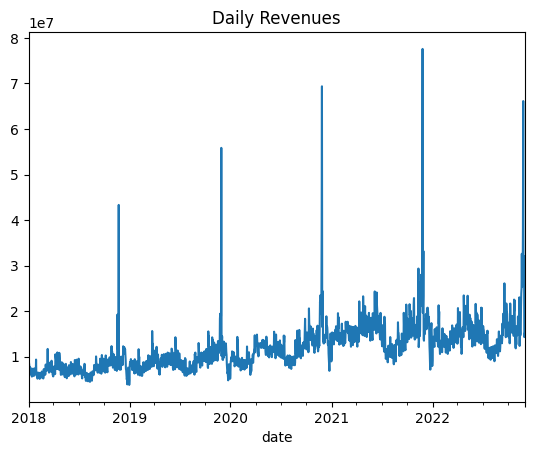

In [ ]:
# Daily revenues line plot
df['y'].plot(title = 'Daily Revenues')
plt.show()

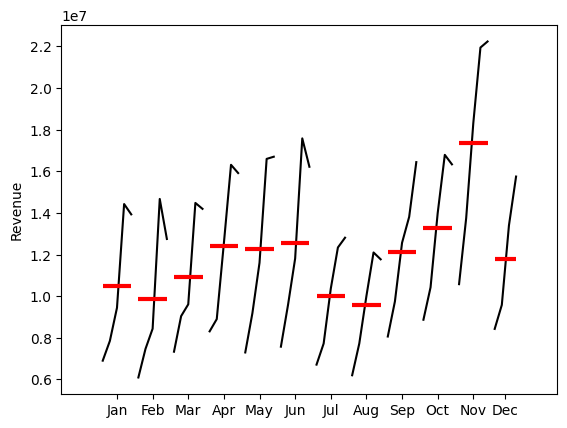

In [ ]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

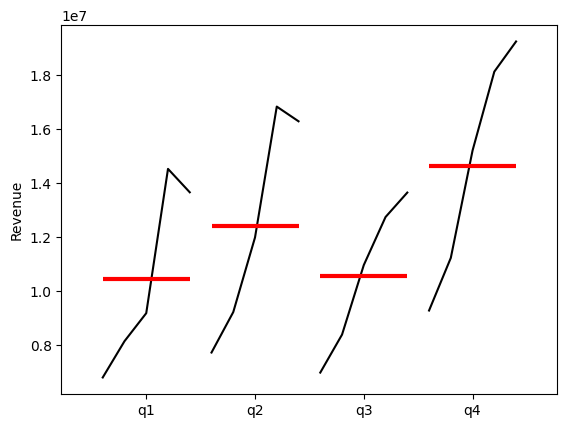

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

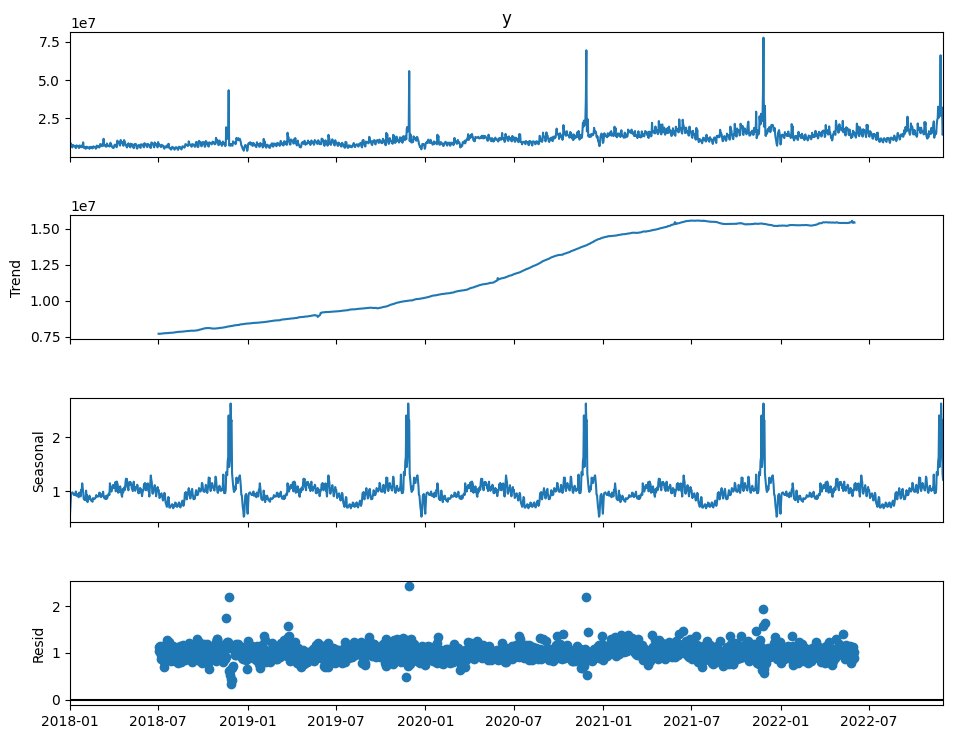

In [ ]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


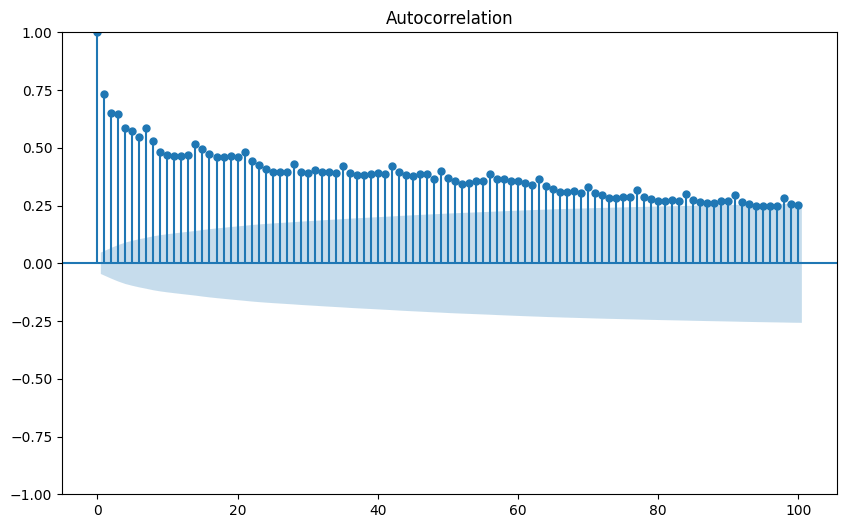

In [ ]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

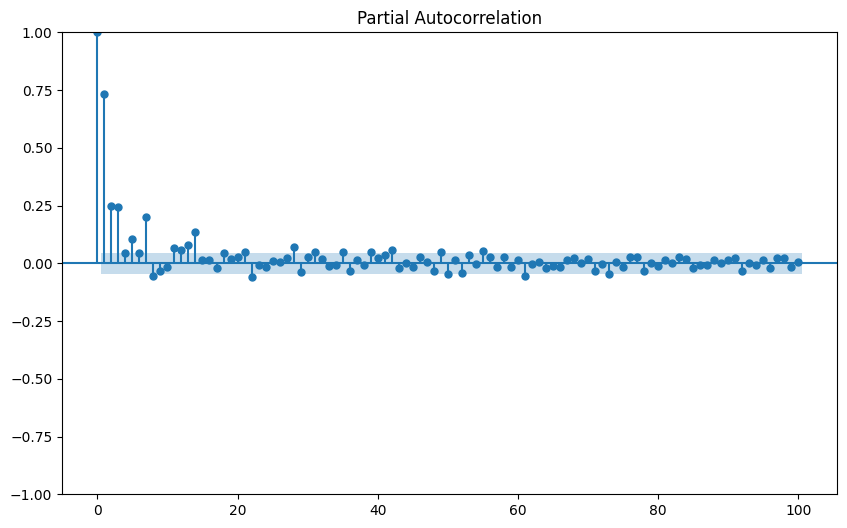

In [ ]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

`.resample()` offset aliases:
- B = business day
- D = calendar day
- W = weekly
- M = month end
- BM = business month end
- MS = month start
- BMS = business month start
- Q = quarter end
- BQ = business quarter end
- QS = quarter start
- BQS = business quarter start
- A = year end
- BA = business year end
- AS = year start
- BAS = business year start
- h = hourly
- min = minutely
- s = secondly
- ms = milliseconds
- us = microseconds

# Stationarity

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

 Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

 The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.101904
Evidence suggests that the time series is not stationary.


In [ ]:
# Compute the first difference of the 'y' column in DataFrame 'df' and assign it to a new column 'y_diff'.
# '.diff()' calculates the difference between consecutive elements along the specified axis (by default axis 0).
# 'dropna()' removes any rows with NaN values resulting from differencing.
df['y_diff'] = df.y.diff().dropna()
df['y_diff']

date
2018-01-01           NaN
2018-01-02     2651237.0
2018-01-03     -475975.0
2018-01-04     -660303.0
2018-01-05    -1410495.0
                 ...    
2022-11-26   -39180777.0
2022-11-27     4955921.0
2022-11-28      210050.0
2022-11-29   -17786305.0
2022-11-30      712049.0
Freq: D, Name: y_diff, Length: 1795, dtype: float64

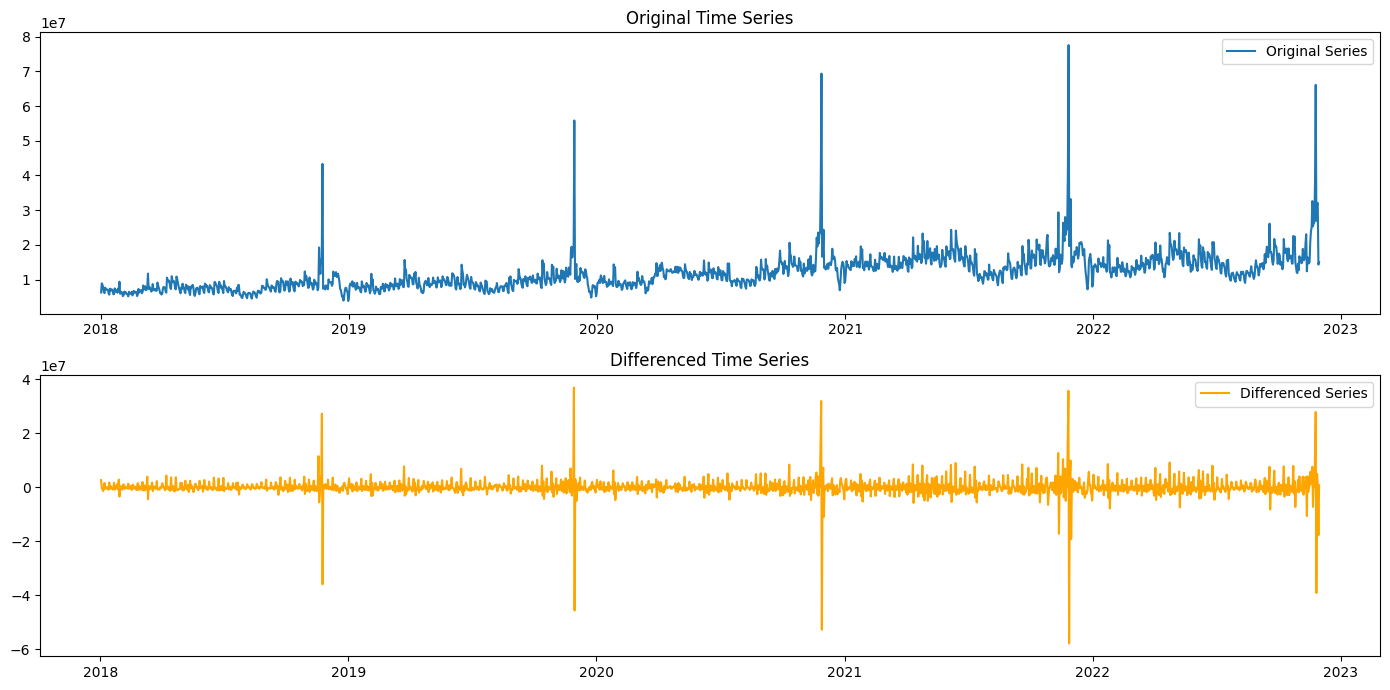

In [ ]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [ ]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


# ARIMA Model

In [ ]:
# Split the Data into training and test
test_days = 30 # Number of days to reserve for testing
train, test = df.iloc[:-test_days], df.iloc[-test_days:]
test

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0
2022-11-06,18835528.0,16.40%,0.31%,3957998.0
2022-11-07,16094516.0,17.11%,0.30%,-2741012.0
2022-11-08,15589508.0,16.64%,0.29%,-505008.0
2022-11-09,16608320.0,18.72%,0.74%,1018812.0


In [ ]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# 'seasonal=False' indicates that the model should not consider seasonal components.
model = auto_arima(train['y'],
                   seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Sat, 03 Feb 2024   AIC                          57650.535
Time:                        12:30:30   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+42. Standard errors may be unstable.
"""

In [ ]:
# Use the fitted ARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_arima = model.predict(n_periods = len(test))
predictions_arima

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

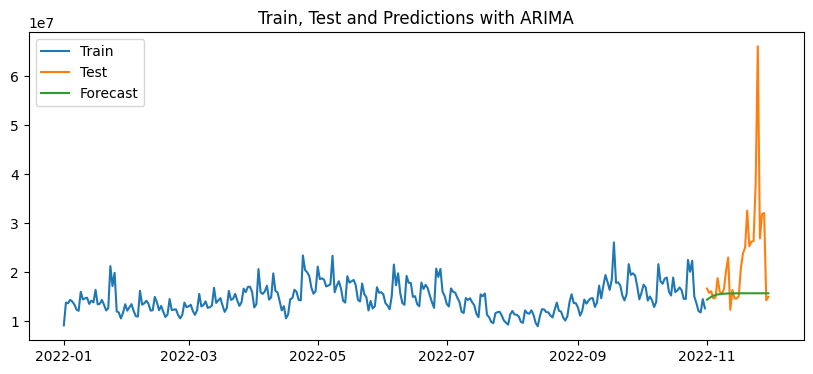

The MAE is 7267306.02
The RMSE is 12366038.29
The MAPE is 24.15 %


In [ ]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_arima, "ARIMA")

# SARIMA

In [ ]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
model_sarima = auto_arima(train['y'],
                          m = 7)
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Sat, 03 Feb 2024   AIC                          57546.103
Time:                                   12:35:12   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4683.063      2.150      0.032     889.683    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848628.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [ ]:
# Use the fitted SARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_sarima = model_sarima.predict(n_periods = len(test))
predictions_sarima

2022-11-01    1.513413e+07
2022-11-02    1.504531e+07
2022-11-03    1.464456e+07
2022-11-04    1.382187e+07
2022-11-05    1.398001e+07
2022-11-06    1.697840e+07
2022-11-07    1.583295e+07
2022-11-08    1.605198e+07
2022-11-09    1.575788e+07
2022-11-10    1.523578e+07
2022-11-11    1.428025e+07
2022-11-12    1.448983e+07
2022-11-13    1.761280e+07
2022-11-14    1.658417e+07
2022-11-15    1.682753e+07
2022-11-16    1.635479e+07
2022-11-17    1.582114e+07
2022-11-18    1.482102e+07
2022-11-19    1.499260e+07
2022-11-20    1.780752e+07
2022-11-21    1.673557e+07
2022-11-22    1.694566e+07
2022-11-23    1.665814e+07
2022-11-24    1.616886e+07
2022-11-25    1.526414e+07
2022-11-26    1.547003e+07
2022-11-27    1.842676e+07
2022-11-28    1.745374e+07
2022-11-29    1.769214e+07
2022-11-30    1.726661e+07
Freq: D, dtype: float64

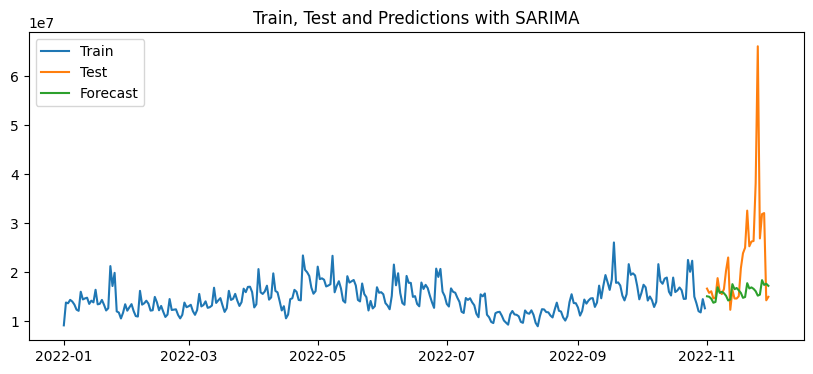

The MAE is 7210576.21
The RMSE is 12152429.39
The MAPE is 24.54 %


In [ ]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarima, "SARIMA")

* The MAE is 7267306.02
* The RMSE is 12366038.29
* The MAPE is 24.15 %

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

# SARIMAX

In [ ]:
# Remove '%' symbol from 'discount_rate' and 'coupon_rate' column and convert to float
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)

# Print the information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [ ]:
# Split the Regressor Data into training and test
test_days = 30 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [ ]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
# X =  exogenous variables.
model_sarimax = auto_arima(train['y'],
                           m = 7,
                           X = exog_train)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Sat, 03 Feb 2024   AIC                          57250.045
Time:                                   12:39:23   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7880.847      2.082      0.037     964.544    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.156      0.000    8.04e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.198      0.000      -0.957      -0.348
ar.L2             0.1827      0.049      3.766      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.197       0.410
ma.L2            -0.6922      0.124     -5.567      0.000      -0.936      -0.449
ar.S.L7           0.0524      0.187      0.280      0.780      -0.315       0.419
ar.S.L14          0.8999      0.178      5.062      0.000       0.551       1.248
ma.S.L7           0.0182      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8501      0.161     -5.286      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.82e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075250.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.85e+29. Standard errors may be unstable.
"""

In [ ]:
# Use the fitted SARIMAX model to forecast future values.
# set the number of periods to forecast to the length of 'test'
# X - representing the exogenous variables for forecasting
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax

2022-11-01    1.675203e+07
2022-11-02    1.494534e+07
2022-11-03    1.488390e+07
2022-11-04    1.296350e+07
2022-11-05    1.205396e+07
2022-11-06    1.394979e+07
2022-11-07    1.341718e+07
2022-11-08    1.328240e+07
2022-11-09    1.441167e+07
2022-11-10    2.077564e+07
2022-11-11    2.121799e+07
2022-11-12    1.346271e+07
2022-11-13    1.489144e+07
2022-11-14    1.299943e+07
2022-11-15    1.348092e+07
2022-11-16    1.398057e+07
2022-11-17    1.803900e+07
2022-11-18    1.675077e+07
2022-11-19    1.712282e+07
2022-11-20    1.980837e+07
2022-11-21    1.847937e+07
2022-11-22    1.908261e+07
2022-11-23    1.913662e+07
2022-11-24    2.068928e+07
2022-11-25    1.926277e+07
2022-11-26    1.851257e+07
2022-11-27    2.073316e+07
2022-11-28    2.608044e+07
2022-11-29    1.588333e+07
2022-11-30    1.480004e+07
Freq: D, dtype: float64

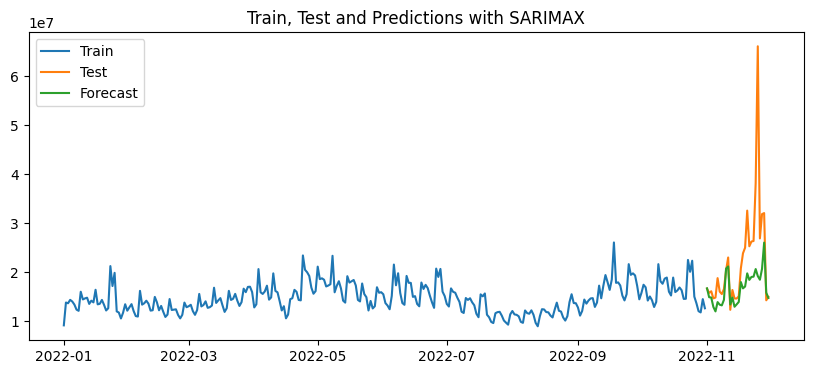

The MAE is 5716506.24
The RMSE is 10394553.04
The MAPE is 19.36 %


In [ ]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarimax, "SARIMAX")

# Cross Validation

In [ ]:
# Define the model to do CV
# order = ([p] autoregressive order, [d] differencing order, [q] moving average order)
# seasonal_order = ([P] seasonal autoregressive order, [D] seasonal differencing order, [Q] seasonal moving average order, [m] number of periods per season)
model_cv = ARIMA(order = (2, 1, 2), seasonal_order = (2, 0, 2, 7))

In [ ]:
# Define the rules for Rolling Forecast Cross-Validation (RollingForecastCV).
cv = model_selection.RollingForecastCV(h = 30, # forecast horizon
                                       step = 15, # moves the validation window by n time steps each iteration
                                       initial = df.shape[0] - 180) # starting point for the first training set

In [ ]:
# Perform cross-validation scoring using specified inputs.
cv_score = model_selection.cross_val_score(model_cv,
                                           y=df['y'],  # Target variable 'y'
                                           X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                           scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                           cv=cv,  # Cross-validation strategy
                                           verbose=1,  # Verbosity level
                                           error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                           )


In [ ]:
# Calculate Root Mean Squared Error (RMSE) using cross-validated scores.
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 4405840


# Parameter Tuning

In [ ]:
# Defining the parameters
param_grid = {'p': [1,2,3],
              'd': [0,1],
              'q': [1,2,3],
              'P': [1,2],
              'D': [0],
              'Q': [1,2]}
grid = ParameterGrid(param_grid)
len(list(grid))

72

In [ ]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 7))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = model_selection.RollingForecastCV(h=30,
                                         step=15,
                                         initial=df.shape[0] - 180)

  # Perform cross-validation scoring with the ARIMA model
  cv_score = model_selection.cross_val_score(model,
                                             y=df['y'],  # Target variable 'y'
                                             X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  rmse_list.append(rmse)


In [ ]:
# Create a DataFrame to store the tuning results with parameters and corresponding RMSE values
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['rmse'] = rmse_list

tuning_results

In [ ]:
# Save the best parameters
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params

,37
D,0.000000e+00
P,2.000000e+00
Q,1.000000e+00
d,0.000000e+00
p,1.000000e+00
q,2.000000e+00
rmse,4.014443e+06


# Predicting the future

In [ ]:
# target variable - daily revenue
y = df['y']
# exogenous variables
X = df.iloc[:,1:3]

In [ ]:
# Fetch the best parameters
p = int(best_params.loc['p'])
d = int(best_params.loc['d'])
q = int(best_params.loc['q'])
P = int(best_params.loc['P'])
D = int(best_params.loc['D'])
Q = int(best_params.loc['Q'])

In [ ]:
# Loading the future regressors data and set the date as index
df_future = pd.read_csv("future_regressors.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df_future.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [ ]:
# multiply all regressor columns by 100
# to make it as percentage values
X_future = df_future.iloc[:,1:3] * 100

In [ ]:
# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (p, d, q),
                    seasonal_order = (P, D, Q, 7))
# fit the model, add exogenous variables as X
tuned_model.fit(y, X = X)

ARIMA(order=(1, 0, 2), seasonal_order=(2, 0, 1, 7))

In [ ]:
# Forecasting
# set the number of periods to forecast to the length of 'X_future'
# add future exogenous variables as X
predictions = tuned_model.predict(n_periods = len(X_future),
                                  X = X_future)

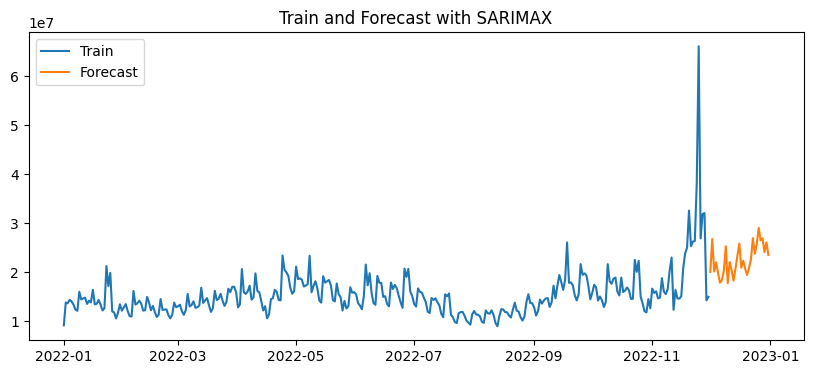

In [ ]:
# Data Visualization
plot_future(y['2022':], predictions, "SARIMAX")

Left to do: Feature Engineering